In [15]:
# -*- coding: utf-8 -*-
from numpy import *
import operator

In [3]:
def createDataSet():
    group = array([[1.0, 1.1], [1.0, 1.0], [0, 0], [0, 0.1]])
    labels = ['A', 'A', 'B', 'B']
    return group, labels

In [4]:
group, labels = createDataSet()

In [57]:
def classify0(inX, dataSet, labels, k):
    # 获取数据集长度
    dataSetSize = dataSet.shape[0]
    # tile(x, (row,column)) 将x在行上重复row次，在列上重复column次
    # 求输入inX与数据集里每个点的距离平方,假设输入为[x, y]， 数据集为group
    diffMat = tile(inX, (dataSetSize, 1)) - dataSet
    sqDiffMat = diffMat ** 2
    # 在行上求和，例如训练集的第一个实例 即求(x-1)^2 + (y-1.1)^2 即为输入inX与第一个实例点的距离平方，最后求得inX与每个实例的距离平方
    sqDistances = sqDiffMat.sum(axis=1)
    # 距离平方开根号即为距离
    distances = sqDistances ** 0.5
    # argsort是排序，将元素按照由小到大的顺序返回下标
    sortedDistIndicies = distances.argsort()
#     print(sortedDistIndicies)
    classCount = {}
    for i in range(k):
        # 获取前k个距离最小的实例的标签
        voteIlabel = labels[sortedDistIndicies[i]]
        # 该标签若不存在则创建并计数为1，存在则更新，令其值+1
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1
#         print(classCount)
    # 遍历classCount这一字典中所有的元组，然后按照value进行降序排列，
    # 下列代码将classCount分解为(键名，键值)的元组列表，然后用 key=operator.itemgetter(1)按照元组的第二个元素进行排序
    # reverse = True即为降序排列，
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    #print(sortedClassCount)
    # 返回标签计数最多的类别
    return sortedClassCount[0][0]

In [17]:
test = classify0([2,2], group, labels, 3)
print(test)

[('A', 2), ('B', 1)]
A


In [58]:
def file2matrix(filename):
    fr = open(filename)
    arrayOLines = fr.readlines()
    # 获取文件行数
    numberOfLines = len(arrayOLines)
    # 创建(numberOfLines行，3列)的矩阵
    returnMat = zeros((numberOfLines, 3))
    classLabelVector = []
    index = 0
    for line in arrayOLines:
        # 去除首尾空格
        line = line.strip()
        # 分割每列数据
        listFromLine = line.split('\t')
        # 将前三列作为数据存进矩阵
        returnMat[index, :] = listFromLine[0:3]
        # 将列表的最后一列数值(即label值)存进标签向量
        classLabelVector.append(int(listFromLine[-1]))
        # 看一看数据都是些什么
#         if index <=1:
#             print(line)
#             print(listFromLine)
#             print(returnMat[index])
#             print(classLabelVector)
        index += 1
    # 返回数据集和标签
    return returnMat, classLabelVector

In [53]:
datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')

In [17]:
import matplotlib
from matplotlib import pyplot as plt
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

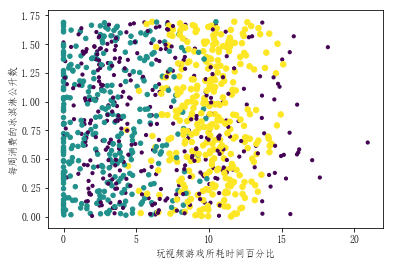

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
# scatter参数为[x轴为第二列数据，y轴为第三列数据，散点的大小，散点的颜色]
ax.scatter(datingDataMat[:,1],datingDataMat[:,2],10.0*array(datingLabels),array(datingLabels))
ax.set_xlabel('玩视频游戏所耗时间百分比')
ax.set_ylabel('每周消费的冰淇淋公升数')
plt.show()

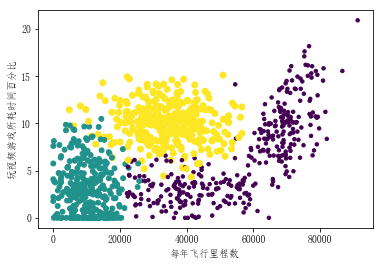

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
# scatter参数为[x轴为第二列数据，y轴为第三列数据，散点的大小，散点的颜色]
ax.scatter(datingDataMat[:,0],datingDataMat[:,1],12.0*array(datingLabels),array(datingLabels))
ax.set_xlabel('每年飞行里程数')
ax.set_ylabel('玩视频游戏所耗时间百分比')
plt.show()

In [59]:
def autoNorm(dataSet):
    # 参数0使得函数可以从列中选取最小值而不是选取当前行最小值
    # minVals  maxVals  ranges' shape are all (1, 3)
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    
    # 获取特征的范围
    ranges = maxVals - minVals
    # 创建一个和数据集相同shape的新矩阵，用于存归一化后的数据
    normDataSet = zeros(shape(dataSet))
    # 获取数据集行数
    m = dataSet.shape[0]
    # 在每行上都减去最小值
    normDataSet = dataSet - tile(minVals, (m, 1))
    # 在每行上都除以范围
    normDataSet = normDataSet / tile(ranges, (m, 1))
    return normDataSet, ranges, minVals

In [60]:
normMat, ranges, minVals = autoNorm(datingDataMat)

In [81]:
def datingClassTest():
    # 抽取10%为测试集
    hoRatio = 0.10
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges ,minVals = autoNorm(datingDataMat)
    m = normMat.shape[0]
    print('length of dataset: ',m)
    numTestVecs = int(m * hoRatio)
    errorCount = 0.0
    # 取前10%的训练集做测试集，余下的做为训练集，输入到分类器中
    # labels中3是特别喜欢，2是有点喜欢，1是根本不喜欢
    for i in range(numTestVecs):
        classifierResult = classify0(normMat[i, :], normMat[numTestVecs:m, :],\
                                    datingLabels[numTestVecs:m], 3)
        #print('The classifier came back with: %d, the real answer is: %d'\
        #     %(classifierResult, datingLabels[i]))
        if (classifierResult != datingLabels[i]):
            errorCount += 1.0
    print('The total error rate is: %f %%' %(errorCount/float(numTestVecs) * 100))

In [82]:
datingClassTest()

length of dataset:  1000
The total error rate is: 5.000000 %


In [89]:
def classifyPerson():
    resultList = ['not at all', 'in small doses', 'in large doses']
    percentTimeOnGame = float(input("percentage of time spent playing video games? "))
    ffMiles = float(input("frequent flier miles earned per year? "))
    iceCream = float(input('liters of ice cream consumed per year? '))
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges ,minVals = autoNorm(datingDataMat)
    inArr = array([ffMiles, percentTimeOnGame, iceCream])
    classifierResult = classify0((inArr-minVals)/ranges, normMat, datingLabels,3)
    print("You will probably like this person:", resultList[classifierResult - 1])

In [91]:
classifyPerson()

percentage of time spent playing video games? 0
frequent flier miles earned per year? 20000
liters of ice cream consumed per year? 5
You will probably like this person: in small doses


In [99]:
# 以下为手写识别系统实例
from os import listdir

In [100]:
def img2vector(filename):
    returnVect = zeros((1, 1024))
    fr = open(filename)
    # 选取第i行
    for i in range(32):
        lineStr = fr.readline()
        # 选取第i行的第j列
        for j in range(32):
            # 拼接32行的32个元素成一维向量
            returnVect[0, 32*i + j] = int(lineStr[j])
    return returnVect

In [101]:
testVector = img2vector('testDigits/0_13.txt')
print(testVector[0,0:31])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


In [106]:
def handwritingClassTest():
    # 初始化手写标签
    hwLabels = []
    # 列出trainingDigits中的文件名
    trainingFileList = listdir('trainingDigits/')
    # 获得文件数量
    m = len(trainingFileList)
    # 初始化一个m*1024的训练矩阵，每行数据存储一个图像
    trainingMat = zeros((m,1024))
    for i in range(m):
        # 按照文件名格式分解处理，文件命名规则如下：9_45.txt的分类是9，它是数字9的第45个实例
        fileNameStr = trainingFileList[i]
        # 按'.'分解，取第一个即'9_45'
        fileStr = fileNameStr.split('.')[0]
        # 按'_'分解，取第一个即 9，即为标签
        classNumStr = int(fileStr.split('_')[0])
        # 将第i个文件的标签添加进标签集
        hwLabels.append(classNumStr)
        # 将第i个文件的数据添加到矩阵的第i行
        trainingMat[i,:] = img2vector("trainingDigits/%s"%fileNameStr)
    testFileList = listdir('testDigits/')
    errorCount = 0.0
    mTest = len(testFileList)
    for i in range(mTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        vectorUnderTest = img2vector("testDigits/%s"%fileNameStr)
        classifierResult = classify0( vectorUnderTest,trainingMat,hwLabels,3)
        print("the classifier came back with: %d,the real answer is %d"%(classifierResult,classNumStr))
        if (classifierResult != classNumStr):
            errorCount += 1.0
    print("\n the total number of errors is: %d"%errorCount)
    print("\n the total error rate is: %f %%"%(errorCount/float(mTest) * 100))

In [107]:
handwritingClassTest()

the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back with: 0,the real answer is 0
the classifier came back wit

the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back with: 1,the real answer is 1
the classifier came back wit

the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back with: 3,the real answer is 3
the classifier came back wit

the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back with: 4,the real answer is 4
the classifier came back wit

the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back with: 6,the real answer is 6
the classifier came back wit

the classifier came back with: 7,the real answer is 7
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 6,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 8,the real answer is 8
the classifier came back with: 3,the real answer is 8
the classifier came back wit

the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back with: 9,the real answer is 9
the classifier came back wit